In [1]:
%load_ext cudf.pandas

# Computational Patterns

Often when writing code we repeat certain patterns, whether we realize it or not.
If you have learned to write list comprehensions, you are taking advantage of a "control pattern".
Often, these patterns are so common that many packages have built in functions to implement them.

Quoting the [toolz documentation](https://toolz.readthedocs.io/en/latest/control.html):

> The Toolz library contains dozens of patterns like map and groupby. Learning a
> core set (maybe a dozen) covers the vast majority of common programming tasks
> often done by hand. A rich vocabulary of core control functions conveys the
> following benefits:
>
> - You identify new patterns
> - You make fewer errors in rote coding
> - You can depend on well tested and benchmarked implementations

The same is true for xarray.


```{seealso}

The concepts covered here, particularly the emphasis on deleting for loops and focusing on large elements of the computation, are very related to the [array programming style](https://en.wikipedia.org/wiki/Array_programming) or paradigm. See this SciPy 2023 tutorial on ["Thinking Like Arrays"](https://github.com/jpivarski-talks/2023-07-11-scipy2023-tutorial-thinking-in-arrays) by Jim Pivarski if you are interested in these ideas.
```

## Motivation / Learning goals

- Learn what high-level computational patterns are available in Xarray.
- Learn that these patterns replace common uses of the `for` loop.
- Identify when you are re-implementing an existing computational pattern.
- Implement that pattern using built-in Xarray functionality.
- Understand the difference between `map` and `reduce`.

## Xarray's high-level patterns

Xarray allows you to leverage dataset metadata to write more readable analysis
code. The metadata is stored with the data; not in your head.

1. Dimension names: `dim="latitude"` instead of `axis=0`
2. Coordinate "labels": or axis tick labels. `data.sel(latitude=45)` instead of
   `data[10]`

Xarray also provides computational patterns that cover many data
analysis tasks.

Xarray provides methods for high-level analysis patterns:

1. `rolling` :
   [Operate on rolling or sliding (fixed length, overlapping) windows of your data e.g. running mean.](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Operate on blocks (fixed length) of your data (downsample).](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `groupby` :
   [Parse data into groups (using an exact value) and operate on each one (reduce data).](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: [GroupBy after discretizing a numeric (non-exact, e.g. float) variable.](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby_bins.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `weighted`: [Weight your data before reducing.](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions) 


```{note}
The documentation links in this tutorial point to the DataArray implementations of each function, but they are also available for DataSet objects.
```


### Load example dataset


In [2]:
%%cudf.pandas.profile

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# reduce figure size
plt.rcParams["figure.dpi"] = 90
xr.set_options(keep_attrs=True, display_expand_data=False)

da = xr.tutorial.load_dataset("air_temperature", engine="netcdf4").air
monthly = da.resample(time="M").mean()
data = da.isel(time=0)
data.plot();

AttributeError: 'numpy.datetime64' object has no attribute 'replace'

                                                                                                                
                                           Total time elapsed: 14.858 seconds                                   
                                        105 GPU function calls in 0.050 seconds                                 
                                         16 CPU function calls in 0.012 seconds                                 
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ isna                       │ 0          │ 0.000       │ 0.000       │ 8          │ 0.005       │ 0.001       │
│ to_timedelta               │ 0          │ 0.000       │ 0.000       │ 6          │ 0.005       │ 0.001       │
│ ndarray.reshape            │ 0          │ 0.000       │ 0.000       │ 2          │ 0.002       │ 0.001       │
│ Index                      │ 4          │ 0.011       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 44         │ 0.014       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__   │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__      │ 40         │ 0.013       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.min          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.max          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna
- to_timedelta
- ndarray.reshape

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=863354;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [3]:
%%cudf.pandas.profile

da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

                                                                                                               
                                           Total time elapsed: 0.329 seconds                                   
                                        234 GPU function calls in 0.099 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 142        │ 0.043       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 71         │ 0.021       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.012       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

***

### Identifying high-level computation patterns

*or, when should I use these functions?*

Consider a common use case. We want to complete some "task" for each of "something". The "task" might be a computation (e.g. mean, median, plot). The "something" could be a group of array values (e.g. pixels) or segments of time (e.g. monthly or seasonally).

Often, our solution to this type of problem is to write a for loop. Say we want the average air temperature for each month across the entire domain (all lat and lon values):

In [4]:
%%cudf.pandas.profile

months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
avg_temps = []

# for loop
for mon in months:
    # filter data, split out in to groups
    subset = da[da["time.month"] == mon]
    # do some computation
    avg = subset.mean()
    # append to existing results
    avg_temps.append(avg.item())

print(avg_temps)

[273.416748046875, 273.13104248046875, 275.1137390136719, 278.5469970703125, 283.299072265625, 287.5657043457031, 289.90692138671875, 290.089111328125, 287.41375732421875, 283.6811828613281, 277.9678039550781, 274.35107421875]


                                                                                                                
                                           Total time elapsed: 1.998 seconds                                    
                                        972 GPU function calls in 1.066 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 552        │ 0.191       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 36         │ 0.015       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 12         │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 12         │ 0.012       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 12         │ 0.028       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 12         │ 0.005       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 24         │ 0.116       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__             │ 12         │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 168        │ 0.052       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__   │ 24         │ 0.019       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 24         │ 0.009       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 24         │ 0.048       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.nonzero            │ 12         │ 0.267       │ 0.022       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__getitem__        │ 12         │ 0.258       │ 0.021       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 24         │ 0.013       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.equals       │ 12         │ 0.019       │ 0.002       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

This pattern is the GroupBy pattern.


An easy conceptual next step for this example (but still using our for loop) would be to use Xarray's `groupby` function to create an iterator that does the work of grouping our data by month and looping over each month.

In [5]:
%%cudf.pandas.profile

avg_temps = []

for label, group in da.groupby("time.month"):
    avg_temps.append(float(group.mean().data))

print(avg_temps)

[273.416748046875, 273.13104248046875, 275.1137390136719, 278.5469970703125, 283.299072265625, 287.5657043457031, 289.90692138671875, 290.089111328125, 287.41375732421875, 283.6811828613281, 277.9678039550781, 274.35107421875]


                                                                                                                
                                           Total time elapsed: 0.302 seconds                                    
                                        128 GPU function calls in 0.138 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 85         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 15         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 8          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 12         │ 0.089       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Writing a for-loop here is not wrong, but it can quickly become cumbersome if you have a complex function to apply and it will take a while to compute on a large dataset (you may even run out of memory). Parallelizing the computation would take a lot of additional work.

Xarray's functionality instead allows us to do the same computation in one line of code (plus, the computation is optimized and ready to take advantage of parallel compute resources)!

In [6]:
%%cudf.pandas.profile

# note the use of the ellipses here
# for easy comparison to the for loop above
avg_temps = da.groupby("time.month").mean(...)
print(avg_temps.data)

[273.41675 273.13104 275.11374 278.547   283.29907 287.5657  289.90692
 290.0891  287.41376 283.68118 277.9678  274.35107]


                                                                                                                
                                           Total time elapsed: 0.178 seconds                                    
                                         71 GPU function calls in 0.042 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 41         │ 0.015       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 4          │ 0.003       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 14         │ 0.004       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{note}
:class: dropdown
By default, `da.mean()` (and `df.mean()`) will calculate the mean by reducing your data over all dimensions (unless you specify otherwise using the `dim` kwarg). The default behavior of `.mean()` on a groupby is to calculate the mean over all dimensions of the variable you are grouping by - but not all the dimensions of the object you are operating on. To compute the mean across all dimensions of a groupby, we must specify `...` for all dimensions (or use the `dim` kwarg to specify which dimensions to reduce by).

```

Here we showed an example for computing a mean over a certain period of time (months), which ultimately uses the `GroupBy` function to group together observations with similar characteristics that are scattered through the dataset. The transition from loops to a built-in function is similar for `rolling` and `coarsen` over sequential windows of values (e.g. pixels) instead of "groups" of time.

Read on through this tutorial to learn some of the incredible ways to use Xarray to avoid writing long for-loops and efficiently complete computational analyses on your data.

```{seealso}
:class: dropdown
For a more complex example (identifying flood events - including their start and end date - from rainfall data) illustrating the transition from for loops to high level computation tools, see [this discussion](https://github.com/pydata/xarray/discussions/7641). The [original 40 lines of code](https://github.com/pydata/xarray/discussions/7641#discussion-4976005), including nested for loops, was streamlined into a ~15 line workflow without any loops.
```

***

### Concept refresher: "index space" vs "label space"


In [7]:
%%cudf.pandas.profile

data

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.229 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [8]:
%%cudf.pandas.profile

# index space
data[10, :]  # 10th element along the first axis; ¯\_(ツ)_/¯

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.234 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [9]:
%%cudf.pandas.profile

# slightly better index space
data.isel(lat=10)  # slightly better, 10th element in latitude

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.227 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [10]:
%%cudf.pandas.profile

# "label" space
data.sel(lat=50)  # much better! lat=50°N

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.212 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [11]:
%%cudf.pandas.profile

# What I wanted to do
data.sel(lat=50)

# What I had to do (if I wasn't using xarray)
data[10, :]

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.214 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

***

## Xarray provides patterns in both "index space" and "label space"

### Index space

These are sequential windowed operations with a window of a fixed size.

1. `rolling` :
   [Operate on rolling or sliding (fixed length, overlapping) windows of your data e.g. running mean.](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Operate on blocks (fixed length) of your data (downsample).](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)


### Label space

These are windowed operations with irregular windows based on your data. Members of a single group may be non-sequential and scattered through the dataset.

1. `groupby` :
   [Parse data into groups (using an exact value) and operate on each one (reduce data).](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: [GroupBy after discretizing a numeric (non-exact, e.g. float) variable.](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby_bins.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)


add some "loop" versions to show what a user might come up with that could be turned into one of these pattern operations

---

## Index space: windows of fixed width

### Sliding windows of fixed length: [`rolling`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.rolling.html)

- Supports common reductions : `sum`, `mean`, `count`, `std`, `var` etc.
- Returns object of same shape as input
- Pads with NaNs to make this happen
- Supports multiple dimensions

Here's the dataset


In [12]:
%%cudf.pandas.profile

data.plot();

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.214 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

And now smoothed 5 point running mean in lat and lon


In [13]:
%%cudf.pandas.profile

data.rolling(lat=5, lon=5, center=True).mean().plot();

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.220 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

#### Apply an existing numpy-only function with `reduce`

In some cases, we may want to apply a sliding window function using rolling that is not built in to Xarray. In these cases we can still leverage the sliding windows of rolling and apply our own function with [`reduce`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.reduce.html).

The `reduce` method on Xarray objects (e.g. DataArray, Dataset) expects a function that can *receive and return plain arrays (e.g. numpy)*, as in each of the "windows" provided by the rolling iterator. This is in contrast to the `map` method on DataArray and Dataset objects, which expects a function that can receive and return Xarray objects.

Here's an example function: [`np.ptp`](https://numpy.org/doc/stable/reference/generated/numpy.ptp.html).


In [14]:
%%cudf.pandas.profile

data.rolling(lat=5, lon=5, center=True).reduce(np.ptp).plot();

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.223 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{exercise}
:label: rolling-reduce

Calculate the rolling mean in 5 point bins along both latitude and longitude using
[`rolling(...).reduce`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.reduce.html)

```

````{solution} rolling-reduce
:class: dropdown

```python
# exactly equivalent to data.rolling(...).mean()
data.rolling(lat=5, lon=5, center=True).reduce(np.mean).plot();
```

````

#### View the `rolling` operation as a Xarray object with `construct`

In the above examples, we plotted the outputs of our rolling operations. Xarray makes it easy to integrate the outputs from `rolling` directly into the DataArray using the [`construct`](https://docs.xarray.dev/en/stable/generated/xarray.core.rolling.DataArrayRolling.construct.html#xarray.core.rolling.DataArrayRolling.construct) method.

In [15]:
%%cudf.pandas.profile

simple = xr.DataArray(np.arange(10), dims="time", coords={"time": np.arange(10)})
simple

<xarray.DataArray (time: 10)>
0 1 2 3 4 5 6 7 8 9
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9

                                                                                                             
                                          Total time elapsed: 0.147 seconds                                  
                                       107 GPU function calls in 0.040 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 95         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [16]:
%%cudf.pandas.profile

# adds a new dimension "window"
simple.rolling(time=5, center=True).construct("window")

<xarray.DataArray (time: 10, window: 5)>
nan nan 0.0 1.0 2.0 nan 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 nan 7.0 8.0 9.0 nan nan
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

                                                                                                             
                                          Total time elapsed: 0.149 seconds                                  
                                       91 GPU function calls in 0.036 seconds                                
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__      │ 81         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 7          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{note}
:class: dropdown
Because `.construct()` only returns a "view" (not a copy) of the original data object (i.e. it is not operating "in-place"), in order to "save" the results you would need to rewrite the original object: `simple = simple.rolling(time=5, center=True).construct("window")`.
```

```{exercise}
:label: rolling-construct
Calculate the 5 point running mean in time using `rolling.construct`
```

````{solution} rolling-construct
:class: dropdown

```python
simple.rolling(time=5, center=True).construct("window").mean("window")
```

````


`construct` is clever.

1. It constructs a [**view**](https://numpy.org/doc/stable/user/basics.copies.html) of the original array, so it is memory-efficient.
1. It does something sensible for dask arrays (though generally you want big chunksizes for the dimension you're sliding along).
1. It also works with rolling along multiple dimensions!


#### Advanced: Another `construct` example

This is a 2D rolling example; we need to provide two new dimension names.


In [17]:
%%cudf.pandas.profile

data.rolling(lat=5, lon=5, center=True).construct(lat="lat_roll", lon="lon_roll")

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.228 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

***

### Block windows of fixed length: `coarsen`

For non-overlapping windows or "blocks" use [`coarsen`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.coarsen.html). The syntax is very similar to `rolling`. You will need to specify how you want Xarray to handle the `boundary` if the length of the dimension is not a multiple of the block size.


- Supports common reductions : `sum`, `mean`, `count`, `std`, `var` etc.
- Does **not** return an object of same shape as input
- Allows controls over behaviour at boundaries
- Supports multiple dimensions

In [18]:
%%cudf.pandas.profile

data

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.238 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [19]:
%%cudf.pandas.profile

data.plot();

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.244 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [20]:
%%cudf.pandas.profile

data.coarsen(lat=5, lon=5, boundary="trim").mean()

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.233 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [21]:
%%cudf.pandas.profile

(data.coarsen(lat=5, lon=5, boundary="trim").mean().plot())

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.237 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

#### Coarsen supports `reduce` for custom reductions

```{exercise}
:label: coarsen-reduce
Use `coarsen.reduce` to apply `np.ptp` in 5x5 (lat x lon) point blocks to `data`
```

````{solution} coarsen-reduce
:class: dropdown

```python
data.coarsen(lat=5, lon=5, boundary="trim").reduce(np.mean).plot();
```

````


#### Coarsen supports `construct` for block reshaping and storing outputs

```{tip}
`coarsen.construct` is usually a good alternative to `np.reshape`
```

A simple example splits a 2-year long monthly 1D time series into a 2D array shaped (year x month)


In [22]:
%%cudf.pandas.profile

months = xr.DataArray(
    np.tile(np.arange(1, 13), reps=2),
    dims="time",
    coords={"time": np.arange(1, 25)},
)
months

<xarray.DataArray (time: 24)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24

                                                                                                             
                                          Total time elapsed: 0.154 seconds                                  
                                       107 GPU function calls in 0.041 seconds                               
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Index                   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 95         │ 0.028       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__     │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [23]:
%%cudf.pandas.profile

# break "time" into two new dimensions: "year", "month"
months.coarsen(time=12).construct(time=("year", "month"))

<xarray.DataArray (year: 2, month: 12)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
    time     (year, month) int64 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24
Dimensions without coordinates: year, month

                                                                                                        
                                       Total time elapsed: 0.063 seconds                                
                                     5 GPU function calls in 0.001 seconds                              
                                     0 CPU function calls in 0.000 seconds                              
                                                                                                        
                                                     Stats                                              
                                                                                                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function           ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__len__ │ 5          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Note two things:

1. The `time` dimension was also reshaped.
1. The new dimensions `year` and `month` don't have any coordinate labels
   associated with them.

What if the data had say 23 instead of 24 values (`months.isel(time=slice(1, None)`)? In that case we specify a different `boundary` (the default `boundary="exact"` worked above); here we pad to 24 values.


In [24]:
%%cudf.pandas.profile

months.isel(time=slice(1, None)).coarsen(time=12, boundary="pad").construct(time=("year", "month"))

<xarray.DataArray (year: 2, month: 12)>
2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 ... 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 nan
Coordinates:
    time     (year, month) float64 2.0 3.0 4.0 5.0 6.0 ... 22.0 23.0 24.0 nan
Dimensions without coordinates: year, month

                                                                                                            
                                         Total time elapsed: 0.081 seconds                                  
                                       15 GPU function calls in 0.009 seconds                               
                                       0 CPU function calls in 0.000 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__getitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__     │ 8          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                  │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__   │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

This adds values at the end of the array (see the 'nan' at the end of the time coordinate?), which is not so sensible for this
problem.  We have some control of the padding through the `side` kwarg to `coarsen`. For `side="right"` we get more sensible output.

In [25]:
%%cudf.pandas.profile

months.isel(time=slice(1, None)).coarsen(time=12, boundary="pad", side="right").construct(
    time=("year", "month")
)

<xarray.DataArray (year: 2, month: 12)>
nan 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ... 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Coordinates:
    time     (year, month) float64 nan 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0
Dimensions without coordinates: year, month

                                                                                                            
                                         Total time elapsed: 0.081 seconds                                  
                                       15 GPU function calls in 0.008 seconds                               
                                       0 CPU function calls in 0.000 seconds                                
                                                                                                            
                                                       Stats                                                
                                                                                                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function               ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__getitem__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__     │ 8          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                  │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__   │ 4          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Note that `coarsen` pads with NaNs. For more control over padding, use
[DataArray.pad](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.pad.html) explicitly.

In [26]:
%%cudf.pandas.profile

(
    months.isel(time=slice(1, None))
    .pad(time=(1, 0), constant_values=-1)
    .coarsen(time=12)
    .construct(time=("year", "month"))
)

<xarray.DataArray (year: 2, month: 12)>
-1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
    time     (year, month) float64 nan 2.0 3.0 4.0 5.0 ... 21.0 22.0 23.0 24.0
Dimensions without coordinates: year, month

                                                                                                              
                                          Total time elapsed: 0.094 seconds                                   
                                        29 GPU function calls in 0.012 seconds                                
                                        0 CPU function calls in 0.000 seconds                                 
                                                                                                              
                                                        Stats                                                 
                                                                                                              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                 ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Int64Index.__getitem__   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__       │ 8          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                    │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__len__     │ 15         │ 0.004       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.copy        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float64Index.__setattr__ │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└──────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{note}
The value specified in `.pad` only applies the `fill_value` to the array, not to coordinate variables.
This is why the first value of time in the above example is NaN and not -1.
```

```{exercise}
:label: reshape
Reshape the `time` dimension of the DataArray `monthly` to year x
month and visualize the seasonal cycle for two years at 250°E
```


````{solution} reshape
:class: dropdown

```python
# splits time dimension into year x month
year_month = monthly.coarsen(time=12).construct(time=("year", "month"))

# assign a nice coordinate value for month
year_month["month"] = [
    "jan",
    "feb",
    "mar",
    "apr",
    "may",
    "jun",
    "jul",
    "aug",
    "sep",
    "oct",
    "nov",
    "dec",
]

# assign a nice coordinate value for year
year_month["year"] = [2013, 2014]

# seasonal cycle for two years
year_month.sel(lon=250).plot.contourf(col="year", x="month", y="lat")
```

````




```{exercise}
:label: rolling
Calculate the rolling 4 month average, averaged across years. (This exercise came up during a live lecture).
```


````{solution} rolling
:class: dropdown

1. We first reshape using `coarsen.construct` to add `year` as a new dimension.
2. Apply `rolling` on the month dimension.
3. It turns out that `roll.mean(["year", "month"])` doesn't work. So we use `roll.construct` to get a DataArray with a new dimension `window` and then take the mean over `window` and `year`

```python
reshaped = months.coarsen(time=12).construct(time=("year", "month"))
roll = reshaped.rolling(month=4, center=True)
roll.construct("window").mean(["window", "year"])
```

````

### Summary

Delete your `for` loops. Use `rolling` and `coarsen` for fixed size windowing operations.

1. `rolling` for overlapping windows
1. `coarsen` for non-overlapping windows.

Both provide the usual reductions as methods (`.mean()` and friends), and also
`reduce` and `construct` for custom operations.


***

## Label space "windows" or bins : GroupBy

Sometimes the windows you want are not regularly spaced or even defined by a grid.
For instance, grouping data by month (which have varying numbers of days) or the results of an image classification.
The GroupBy functions are essentially a generalization of `coarsen`: 

- `groupby`: divide data into distinct groups, e.g. climatologies, composites. Works best when the "group identifiers" or "labels" are exact and can be determined using equality (`==`), e.g. characters or integers. Remember that floats are not exact values.
- `groupby_bins`: Use binning operations, e.g. histograms, to group your data.
- `resample`: Specialized implementation of GroupBy specifically for time grouping (so far), allows you to change sampling frequency of dataset.


```{note}
 Both `groupby_bins` and `resample` are implemented as `groupby` with a specific way of constructing group labels. The GroupBy pattern is very flexible!
```


### Deconstructing GroupBy

The GroupBy workflow is commonly called "split-apply-combine".

1. *Split* : break dataset into groups
1. *Apply* : apply an operation, for instance a reduction like `mean`
1. *Combine* : concatenate results from apply step along a new "group" dimension

illustrated in this neat schematic from [Project Pythia](https://foundations.projectpythia.org/core/xarray/computation-masking.html#groupby-split-apply-combine):
<img src="https://foundations.projectpythia.org/_images/xarray-split-apply-combine.jpeg" width=30%>


But really there is a "hidden" first step: *identifying* groups (also called "factorization" or sometimes "binning"). Usually this is the hard part.

In reality the workflow is: "identify groups" → "split into groups" → "apply function" → "combine results".


In [27]:
%%cudf.pandas.profile

# recall our earlier DataArray
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

                                                                                                               
                                           Total time elapsed: 0.308 seconds                                   
                                        234 GPU function calls in 0.094 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 142        │ 0.041       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 71         │ 0.020       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.010       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [28]:
%%cudf.pandas.profile

# GroupBy returns an iterator that traverses the specified groups, here by month.
# Notice that groupby is clever enough for us to leave out the `.dt` before `.month`
# we would need to specify to access the month data directly, as in `da.time.dt.month`.
da.groupby("time.month")

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

                                                                                                                
                                           Total time elapsed: 0.146 seconds                                    
                                         79 GPU function calls in 0.036 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 37         │ 0.013       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 3          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 29         │ 0.009       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__     │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [29]:
%%cudf.pandas.profile

# for each group (e.g. the air temperature in a given month for all the years),
# compute the mean
da.groupby("time.month").mean()

<xarray.DataArray 'air' (month: 12, lat: 25, lon: 53)>
246.3 246.4 246.2 245.8 245.2 244.6 ... 298.1 298.0 298.0 297.6 297.6 297.5
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

                                                                                                                
                                           Total time elapsed: 0.462 seconds                                    
                                        305 GPU function calls in 0.143 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 41         │ 0.015       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 4          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 85         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 142        │ 0.044       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__   │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__     │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__      │ 2          │ 0.015       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__        │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Notice that since we have averaged over all the years for each month, our resulting DataArray no longer has a "year" coordinate.

If we want to see how Xarray identifies "groups" for the monthly climatology computation, we can plot our input to `groupby`. GroupBy is clever enough to figure out how many values there are an thus how many groups to make.


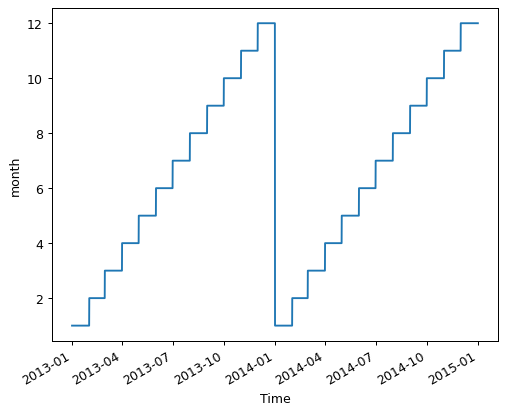

                                                                                                                
                                           Total time elapsed: 3.504 seconds                                    
                                         55 GPU function calls in 0.024 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 47         │ 0.017       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__getitem__        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [30]:
%%cudf.pandas.profile

da["time.month"].plot();

Similarly for binning (remember this is useful when the parameter you are binning over is not "exact", like a float),


In [31]:
%%cudf.pandas.profile

data.groupby_bins("lat", bins=[20, 35, 40, 45, 50])

NameError: name 'data' is not defined

                                                                                              
                                  Total time elapsed: 0.239 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

and resampling...


In [32]:
%%cudf.pandas.profile

da.resample(time="M")

AttributeError: 'numpy.datetime64' object has no attribute 'replace'

                                                                                                                
                                           Total time elapsed: 1.238 seconds                                    
                                         36 GPU function calls in 0.016 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 22         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 8          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.min          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.max          │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

```{note}

Resampling is changing the frequency of our data to monthly (for two years), so we have 24 bins. GroupBy is taking the average across all data in the same month for two years, so we have 12 bins.

```

### Constructing group labels

If the automatic group detection doesn't work for your problem then these functions are useful for constructing specific "group labels" in many cases

1. [numpy.digitize](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html)
   for binning
1. [numpy.searchsorted](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html)
   supports many other data types
1. [pandas.factorize](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.factorize.html)
   supports characters, strings etc.
1. [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html)
   for binning
1. ["Datetime components"](https://docs.xarray.dev/en/stable/user-guide/time-series.html#datetime-components)  of Xarray DataArrays
1. [DataArray.isin](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.isin.html)
1. [scipy.ndimage.label](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.label.html)
1. Do you know of any more? (Send in a pull request to update this list!)



```{tip}
Xarray uses [`pandas.factorize`](https://pandas.pydata.org/docs/reference/api/pandas.factorize.html) for `groupby` and [`pandas.cut`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) for `groupby_bins`.
```

#### ["Datetime components"](https://docs.xarray.dev/en/stable/user-guide/time-series.html#datetime-components) for creating groups

See a full list
[here](https://docs.xarray.dev/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html?highlight=DatetimeAccessor)

These can be accessed in a few different ways as illustrated below.


In [33]:
%%cudf.pandas.profile

da.time

<xarray.DataArray 'time' (time: 2920)>
2013-01-01 2013-01-01T06:00:00 ... 2014-12-31T12:00:00 2014-12-31T18:00:00
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.250 seconds                                   
                                        184 GPU function calls in 0.074 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 171        │ 0.056       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [34]:
%%cudf.pandas.profile

da.time.dt.day

<xarray.DataArray 'day' (time: 2920)>
1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 ... 28 28 28 29 29 29 29 30 30 30 30 31 31 31 31
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.245 seconds                                   
                                        192 GPU function calls in 0.073 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 76         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 98         │ 0.030       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__    │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [35]:
%%cudf.pandas.profile

da["time.day"]

<xarray.DataArray 'day' (time: 2920)>
array([ 1,  1,  1, ..., 31, 31, 31])
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

                                                                                                                
                                           Total time elapsed: 0.198 seconds                                    
                                        124 GPU function calls in 0.055 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 107        │ 0.034       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__repr__           │ 4          │ 0.004       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__     │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [36]:
%%cudf.pandas.profile

da.time.dt.season

<xarray.DataArray 'season' (time: 2920)>
'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF'
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.275 seconds                                   
                                        190 GPU function calls in 0.080 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 76         │ 0.023       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__       │ 98         │ 0.032       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__   │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

#### Construct and use custom labels

##### Custom seasons with `numpy.isin`.

We want to group over four seasons: `DJF`, `MAM`, `JJAS`, `ON` - this makes physical sense in the Indian Ocean basin.

Start by extracting months.


In [37]:
%%cudf.pandas.profile

month = da.time.dt.month.data
month

array([ 1,  1,  1, ..., 12, 12, 12])

                                                                                                             
                                          Total time elapsed: 0.057 seconds                                  
                                       10 GPU function calls in 0.005 seconds                                
                                        0 CPU function calls in 0.000 seconds                                
                                                                                                             
                                                        Stats                                                
                                                                                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                  │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape         │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype          │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__      │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Create a new empty array


In [38]:
%%cudf.pandas.profile

myseason = np.full(month.shape, "    ")
myseason

array(['    ', '    ', '    ', ..., '    ', '    ', '    '], dtype='<U4')

                                                                                              
                                  Total time elapsed: 0.033 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Use `isin` to assign custom seasons,


In [39]:
%%cudf.pandas.profile

myseason[np.isin(month, [12, 1, 2])] = "DJF"
myseason[np.isin(month, [3, 4, 5])] = "MAM"
myseason[np.isin(month, [6, 7, 8, 9])] = "JJAS"
myseason[np.isin(month, [10, 11])] = "ON"

                                                                                              
                                  Total time elapsed: 0.032 seconds                           
                                0 GPU function calls in 0.000 seconds                         
                                0 CPU function calls in 0.000 seconds                         
                                                                                              
                                                Stats                                         
                                                                                              
┏━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
└──────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Turn our new seasonal group array into a DataArray.

In [40]:
%%cudf.pandas.profile

myseason_da = da.time.copy(data=myseason)
myseason_da

<xarray.DataArray 'time' (time: 2920)>
'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF'
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.251 seconds                                   
                                        193 GPU function calls in 0.077 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 79         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__       │ 98         │ 0.031       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__   │ 6          │ 0.008       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

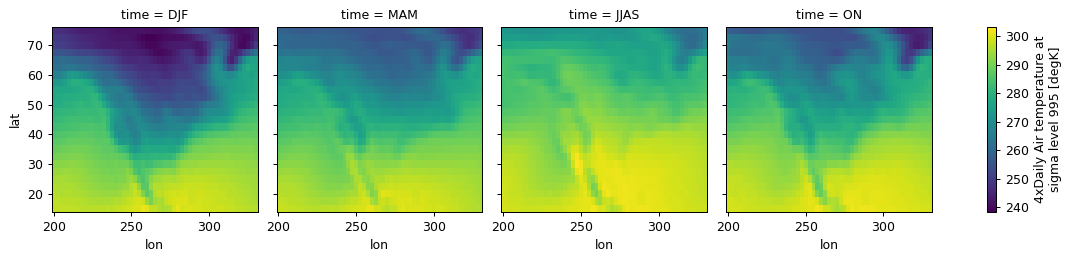

                                                                                                               
                                           Total time elapsed: 4.025 seconds                                   
                                        226 GPU function calls in 0.328 seconds                                
                                         5 CPU function calls in 0.007 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 114        │ 0.037       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 19         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.equals      │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__len__       │ 55         │ 0.018       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy        │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.set_names     │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                 │ 1          │ 0.006       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ Index                     │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__        │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 1          │ 0.017       │ 0.017       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.copy          │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__setattr__   │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.equals        │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__deepcopy__ │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index.get_indexer         │ 0          │ 0.000       │ 0.000       │ 1          │ 0.005       │ 0.005       │
│ ndarray.reshape           │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__lt__            │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.any               │ 1          │ 0.172       │ 0.172       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy         │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.get_loc       │ 5          │ 0.048       │ 0.010       │ 0          │ 0.000       │ 0.000       │
│ StringIndex.__getitem__   │ 5          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ isna                      │ 0          │ 0.000       │ 0.000       │ 4          │ 0.002       │ 0.001       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- Index.get_indexer
- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=6612;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [41]:
%%cudf.pandas.profile

(
    # Calculate climatology
    da.groupby(myseason_da)
    .mean()
    # reindex to get seasons in logical order (not alphabetical order)
    .reindex(time=["DJF", "MAM", "JJAS", "ON"])
    .plot(col="time")
)

##### `floor`, `ceil` and `round` on time

Additional functionality in the [datetime accessor](https://docs.xarray.dev/en/stable/generated/xarray.core.accessor_dt.DatetimeAccessor.html) allows us to effectively "resample" our time data to remove roundoff errors in timestamps.


In [42]:
%%cudf.pandas.profile

da.time

<xarray.DataArray 'time' (time: 2920)>
2013-01-01 2013-01-01T06:00:00 ... 2014-12-31T12:00:00 2014-12-31T18:00:00
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.280 seconds                                   
                                        184 GPU function calls in 0.081 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 171        │ 0.060       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 12         │ 0.013       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

In [43]:
%%cudf.pandas.profile

# remove roundoff error in timestamps
# floor to daily frequency
da.time.dt.floor("D")

<xarray.DataArray 'floor' (time: 2920)>
2013-01-01 2013-01-01 2013-01-01 2013-01-01 ... 2014-12-31 2014-12-31 2014-12-31
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

                                                                                                               
                                           Total time elapsed: 0.320 seconds                                   
                                        191 GPU function calls in 0.090 seconds                                
                                         1 CPU function calls in 0.001 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__     │ 174        │ 0.064       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names   │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                    │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeProperties.floor  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape           │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
│ Index                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 12         │ 0.013       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.009       │ 0.009       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- ndarray.reshape

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=486450;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

##### `strftime` is another powerful option

So useful and so unintuitive that it has its own website: https://strftime.org/

This is useful to avoid merging "Feb-29" and "Mar-01" for a daily climatology


In [44]:
%%cudf.pandas.profile

da.time.dt.strftime("%b-%d")

<xarray.DataArray 'strftime' (time: 2920)>
array(['-01', '-01', '-01', ..., '-31', '-31', '-31'], dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

                                                                                                                 
                                            Total time elapsed: 0.196 seconds                                    
                                         92 GPU function calls in 0.046 seconds                                  
                                          5 CPU function calls in 0.006 seconds                                  
                                                                                                                 
                                                          Stats                                                  
                                                                                                                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                    ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__       │ 82         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Series                      │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ DatetimeProperties.strftime │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape             │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
│ DatetimeIndex.__deepcopy__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__repr__            │ 0          │ 0.000       │ 0.000       │ 4          │ 0.005       │ 0.001       │
│ DatetimeIndex.__getitem__   │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__      │ 1          │ 0.007       │ 0.007       │ 0          │ 0.000       │ 0.000       │
└─────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- ndarray.reshape
- ndarray.__repr__

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=266202;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

### Custom reductions with `GroupBy.reduce`

Analogous to `rolling`, `reduce` and `map` apply custom reductions to `groupby_bins` and `resample`.


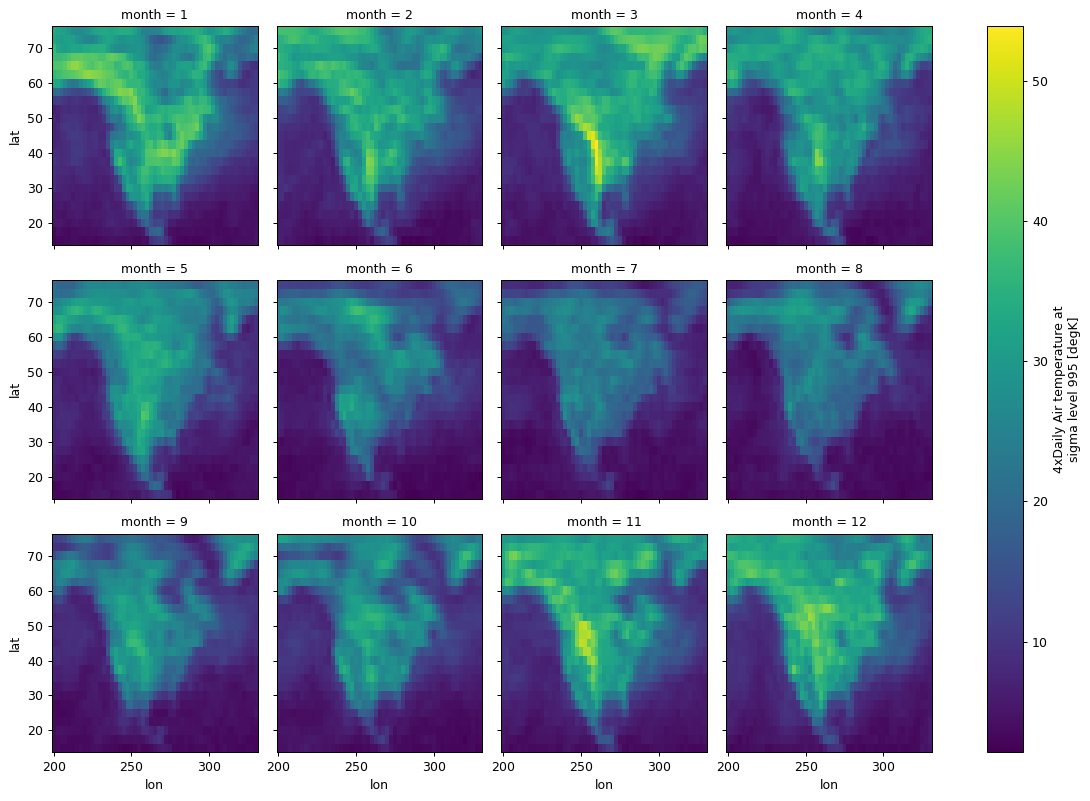

                                                                                                                
                                           Total time elapsed: 12.004 seconds                                   
                                        336 GPU function calls in 0.173 seconds                                 
                                         12 CPU function calls in 0.007 seconds                                 
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 41         │ 0.014       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 4          │ 0.002       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 51         │ 0.015       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 198        │ 0.060       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.get_loc         │ 13         │ 0.051       │ 0.004       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__     │ 13         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ isna                       │ 0          │ 0.000       │ 0.000       │ 12         │ 0.007       │ 0.001       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- isna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=128861;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [45]:
%%cudf.pandas.profile

(da.groupby("time.month").reduce(np.ptp).plot(col="month", col_wrap=4))

```{tip}
 `map` is for functions that expect and return xarray objects (see also [`Dataset.map`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.map.html)). `reduce` is for functions that expect and return plain arrays (like Numpy or SciPy functions).
```


### Viewing the GroupBy operation on your DataArray or DataSet

GroupBy does *not* provide a `construct` method, because all the groups need not be the same "length" (e.g. months can have 28, 29, 30, or 31 days).

#### Instead looping over groupby objects is possible

Because `groupby` returns an iterator that loops over each group, it is easy to loop over groupby objects. You can also iterate over `rolling` and `coarsen` objects, however this approach is usually quite slow.

Maybe you want to plot data in each group separately:


In [46]:
%%cudf.pandas.profile

for label, group in da.groupby("time.month"):
    print(label)

1
2
3
4
5
6
7
8
9
10
11
12


                                                                                                                
                                           Total time elapsed: 0.324 seconds                                    
                                        128 GPU function calls in 0.157 seconds                                 
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 85         │ 0.033       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 15         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 8          │ 0.003       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 12         │ 0.102       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

`group` is a DataArray containing data for all December days (because the last printed `label` value is `12`, so the last `group` value is for December).

In [47]:
%%cudf.pandas.profile

group

<xarray.DataArray 'air' (time: 248, lat: 25, lon: 53)>
268.8 266.6 263.8 260.7 257.6 254.8 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-12-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

                                                                                                               
                                           Total time elapsed: 0.355 seconds                                   
                                        234 GPU function calls in 0.109 seconds                                
                                         0 CPU function calls in 0.000 seconds                                 
                                                                                                               
                                                         Stats                                                 
                                                                                                               
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                  ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Float32Index.__len__      │ 142        │ 0.048       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__  │ 12         │ 0.011       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__     │ 71         │ 0.024       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__ │ 6          │ 0.006       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__     │ 2          │ 0.012       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__repr__    │ 1          │ 0.008       │ 0.008       │ 0          │ 0.000       │ 0.000       │
└───────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Maybe you want a histogram of December temperatures?


(array([  218.,  6763., 32167., 34735., 26251., 29243., 40491., 41906.,
        72286., 44540.]),
 array([221.        , 229.33900452, 237.67799377, 246.01699829,
        254.35598755, 262.69500732, 271.03399658, 279.37298584,
        287.7119751 , 296.05099487, 304.38998413]),
 <BarContainer object of 10 artists>)

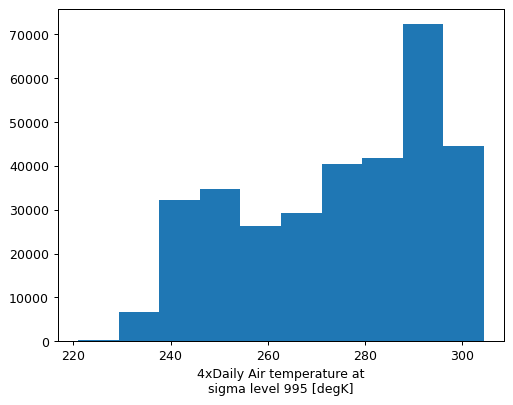

                                                                                                           
                                         Total time elapsed: 0.855 seconds                                 
                                       3 GPU function calls in 0.001 seconds                               
                                       1 CPU function calls in 0.001 seconds                               
                                                                                                           
                                                       Stats                                               
                                                                                                           
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function              ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ notna                 │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
│ Float32Index.__len__  │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__len__ │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
└───────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- notna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=536516;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [48]:
%%cudf.pandas.profile

group.plot.hist()

Remember, this example is just to show how you could operate on each group object in a groupby operation. If we wanted to just explore the December (or March) data, we should just filter for it directly:

(array([  218.,  6763., 32167., 34735., 26251., 29243., 40491., 41906.,
        72286., 44540.]),
 array([221.        , 229.33900452, 237.67799377, 246.01699829,
        254.35598755, 262.69500732, 271.03399658, 279.37298584,
        287.7119751 , 296.05099487, 304.38998413]),
 <BarContainer object of 10 artists>)

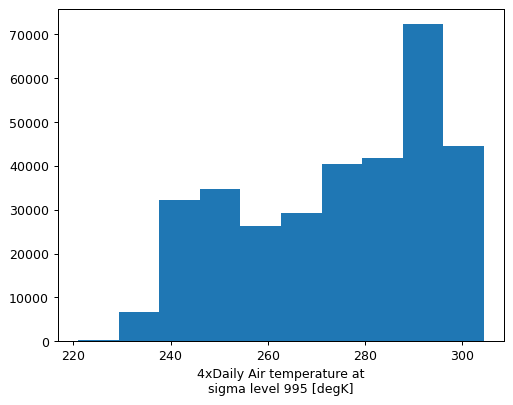

                                                                                                                
                                           Total time elapsed: 0.984 seconds                                    
                                         84 GPU function calls in 0.044 seconds                                 
                                         1 CPU function calls in 0.001 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 47         │ 0.018       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 3          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__eq__             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 16         │ 0.006       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__   │ 2          │ 0.002       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 2          │ 0.005       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ ndarray.nonzero            │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ ndarray.__getitem__        │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.set_names    │ 2          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.equals       │ 1          │ 0.002       │ 0.002       │ 0          │ 0.000       │ 0.000       │
│ notna                      │ 0          │ 0.000       │ 0.000       │ 1          │ 0.001       │ 0.001       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

Not all pandas operations ran on the GPU. The following functions required CPU fallback:

- notna

To request GPU support for any of these functions, please file a Github issue here: 
]8;id=925721;https://github.com/rapidsai/cudf/issues/new?assignees=&labels=%3F+-+Needs+Triage%2C+feature+request&projects=&template=pandas_function_request.md&title=%5BFEA%5D\https://github.com/rapidsai/cudf/issues/new/choose]8;;\.

In [49]:
%%cudf.pandas.profile

da[da["time.month"] == 12].plot.hist()

#### In most cases, avoid a for loop using `map`

`map` enables us to apply functions that expect xarray Datasets or DataArrays. This makes it easy to perform calculations on the grouped data, add the results from each group back to the original object, and avoid having to manually combine results (using concat).


```{tip}
The implementation of `map` *is* a `for` loop. We like `map` because it's cleaner.
```

In [50]:
%%cudf.pandas.profile

def iqr(gb_da, dim):
    """Calculates interquartile range"""
    return (gb_da.quantile(q=0.75, dim=dim) - gb_da.quantile(q=0.25, dim=dim)).rename("iqr")


da.groupby("time.month").map(iqr, dim="time")

<xarray.DataArray 'iqr' (month: 12, lat: 25, lon: 53)>
7.528 7.425 7.025 6.65 6.152 6.135 6.127 ... 0.9 0.9 0.855 1.0 1.3 1.432 1.5
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

                                                                                                                
                                           Total time elapsed: 17.627 seconds                                   
                                        2663 GPU function calls in 1.005 seconds                                
                                         0 CPU function calls in 0.000 seconds                                  
                                                                                                                
                                                         Stats                                                  
                                                                                                                
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Function                   ┃ GPU ncalls ┃ GPU cumtime ┃ GPU percall ┃ CPU ncalls ┃ CPU cumtime ┃ CPU percall ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ DatetimeIndex.__len__      │ 109        │ 0.039       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.copy         │ 15         │ 0.007       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__setattr__  │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__deepcopy__ │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Series                     │ 1          │ 0.003       │ 0.003       │ 0          │ 0.000       │ 0.000       │
│ ndarray.reshape            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ ndarray.astype             │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Index                      │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__len__         │ 85         │ 0.026       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.set_names       │ 1          │ 0.001       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ factorize                  │ 1          │ 0.005       │ 0.005       │ 0          │ 0.000       │ 0.000       │
│ DatetimeIndex.__getitem__  │ 12         │ 0.102       │ 0.008       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__len__       │ 2054       │ 0.635       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.copy          │ 196        │ 0.079       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.equals        │ 114        │ 0.050       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.set_names     │ 44         │ 0.024       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__setattr__   │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.copy            │ 1          │ 0.000       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__setattr__     │ 2          │ 0.001       │ 0.000       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__getitem__   │ 12         │ 0.010       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__getitem__     │ 6          │ 0.005       │ 0.001       │ 0          │ 0.000       │ 0.000       │
│ Float32Index.__repr__      │ 2          │ 0.011       │ 0.006       │ 0          │ 0.000       │ 0.000       │
│ Int64Index.__repr__        │ 1          │ 0.004       │ 0.004       │ 0          │ 0.000       │ 0.000       │
└────────────────────────────┴────────────┴─────────────┴─────────────┴────────────┴─────────────┴─────────────┘

***

## Summary

Xarray provides methods for high-level analysis patterns:

1. `rolling` :
   [Operate on rolling (fixed length, overlapping) windows of your data e.g. running mean.](https://docs.xarray.dev/en/stable/user-guide/computation.html#rolling-window-operations)
1. `coarsen` :
   [Operate on blocks (fixed length) of your data (downsample).](https://docs.xarray.dev/en/stable/user-guide/computation.html#coarsen-large-arrays)
1. `groupby` :
   [Parse data into groups (using an exact value) and operate on each one (reduce data).](https://docs.xarray.dev/en/stable/groupby.html)
1. `groupby_bins`: [GroupBy after discretizing a numeric (non-exact, e.g. float) variable.](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby_bins.html)
1. `resample` :
   [Groupby specialized for time axes. Either downsample or upsample your data.](https://docs.xarray.dev/en/stable/user-guide/time-series.html#resampling-and-grouped-operations)
1. `weighted`: [Weight your data before reducing.](https://docs.xarray.dev/en/stable/user-guide/computation.html#weighted-array-reductions)

Xarray also provides a consistent interface to make using those patterns easy:

1. Iterate over the operators (`rolling`, `coarsen`, `groupby`, `groupby_bins`, `resample`).
1. Apply functions that accept numpy-like arrays with `reduce`.
1. Reshape to a new xarray object with `.construct` (`rolling`, `coarsen` only).
1. Apply functions that accept xarray objects with `map` (`groupby`, `groupby_bins`, `resample` only).
